# Automatic Experiments Analysis

## Summary

This notebook presents the automatic analysis of experiments reported in ... **[PUT THE PAPER LINK]**.
Here, we provide functions to get experiments results from [OpenML](http://www.openml.org/) website, handle them, and output the charts depicted in the paper.


## 1. Setup

First, we need to install all the required packages from CRAN. This can be done using the following commands:

In [117]:
required_packages = c("devtools", "ggplot2", "reshape2", "gridExtra", "mlr", "dplyr")
install.packages(pkgs = required_packages)


  There are binary versions available but the source versions are later:
      binary source needs_compilation
mlr      2.8    2.9              TRUE
RWeka 0.4-26 0.4-29             FALSE


The downloaded binary packages are in
	/var/folders/rj/nq8s_gvj79sc5s0rhhysgs100000gn/T//RtmpkBlTJp/downloaded_packages


installing the source packages 'mlr', 'RWeka'



Then, install the OpenML R package from its [github directory](https://github.com/openml/openml-r). This is made with the command:

In [ ]:
devtools::install_github("openml/r")

The same now for the "farff" package:

In [3]:
devtools::install_github("mlr-org/farff")

from URL https://api.github.com/repos/mlr-org/farff/zipball/master
Installing farff
'/Library/Frameworks/R.framework/Resources/bin/R' --no-site-file --no-environ  \
  --no-save --no-restore --quiet CMD INSTALL  \
  '/private/var/folders/rj/nq8s_gvj79sc5s0rhhysgs100000gn/T/RtmpOOcCS6/devtools6b8e27dd3c7f/mlr-org-farff-4a5aceb'  \
  --library='/Library/Frameworks/R.framework/Versions/3.3/Resources/library'  \
  --install-tests 



Once all the packages are installed, we need to load all of them via *'library'* command:

In [7]:
library("ggplot2")
library("reshape2")
library("gridExtra")
library("OpenML")
library("repr")

Then, we need to setup the OpenML API to get the data and *farff* to read the data from the server :

In [9]:
# Please, replace the OpenML API key with your
setOMLConfig(arff.reader = "farff", apikey = "")

ERROR: Error in checkConfig(conf2): The apikey must contain 32 characters, currently it has 0 characters


## 2. Loading experiments data from OpenML

So, once everything was set up, let's load our data. We would need two parameters here:
* *tag* - the tag that identifies the study/experiment; and
* *numRuns* - the amount of runs executed

The following function, **getExperimentsData()**, will then return all *'numRuns'* run results with the specified *tag*. This data frame is already melted to be handled by our plot functions.


In [98]:
# Arguments:
#  * tag: the study/experiments tag
#  * numRuns: the number of runs that the study/experiment contains
# Output:
#  * data frame object with all run results and information needed to plot them

getExperimentsData = function(tag, numRuns) {

  if(is.null(tag)) {
    stop("You should specifiy a tag to get your OpenML runs!")
  }

  # getting run results from OpenML
  results = do.call("rbind", 
    lapply(0:floor(numRuns/10000), function(i) {
      return(listOMLRunEvaluations(tag = tag, limit = 10000, offset = (10000 * i) + 1))
    })
  )
  
  time.ids = grep("time", colnames(results))
  has.time.measures = length(time.ids) > 0
  
  datasets = listOMLDataSets()
  flows    = listOMLFlows()

  fields = c("run.id", "task.id", "flow.id", "predictive.accuracy", "area.under.roc.curve")
  if(length(time.ids) > 0) {
    fields = c(fields, "usercpu.time.millis.training", "usercpu.time.millis.testing")
  }

  # getting algorithm's name from flows
  temp = results[, fields]
  aux = lapply(1:nrow(temp), function(i) {
    id = which(flows$flow.id == temp$flow.id[i])
    if(length(id) == 0) {
      algo = NA
    } else {
      algo = flows$name[id]
    }

    # get dataset information from datasets list
    task = getOMLTask(task.id = temp$task.id[i])
    data.id = which(datasets$did == task$input$data.set$desc$id)
    data.fields = c("did","name","NumberOfClasses","NumberOfInstances","NumberOfFeatures","MajorityClassSize")
    ret = cbind(algo, datasets[data.id, data.fields])
    return (ret)
  })

  data.temp = do.call("rbind", aux)
  temp = cbind(temp, data.temp)
  temp$perMajClass = temp$MajorityClassSize / temp$NumberOfInstances
  temp$area.under.roc.curve = as.numeric(as.character(temp$area.under.roc.curve))

  # renaming coluns
  colnames(temp)[grep("did", colnames(temp))] = "dataset.id"
  colnames(temp)[grep("name", colnames(temp))] = "dataset.name"
  
  if(length(time.ids) > 0) {
    colnames(temp)[grep("usercpu.time.millis.training", colnames(temp))] = "training.time"
    colnames(temp)[grep("usercpu.time.millis.testing", colnames(temp))]  = "testing.time"
  } else {
    temp$training.time = temp$testing.time = 0
  }

  # removing duplicated runs
  ids = which(duplicated(temp[ ,c("algo", "predictive.accuracy", "area.under.roc.curve", "dataset.id", "dataset.name")]))
  if(length(ids) > 0) {
    temp = temp[-ids, ]
  }

  return(temp)
}


With this function defined we can then get the data from our study **X** using the command:

In [99]:
data = getExperimentsData(tag = "study_7", numRuns = 18000)

It will return a R data frame object with the main characteristics of your runs. It should look like something like this:

In [100]:
head(data)

run.id,task.id,flow.id,predictive.accuracy,area.under.roc.curve,training.time,testing.time,algo,dataset.id,dataset.name,NumberOfClasses,NumberOfInstances,NumberOfFeatures,MajorityClassSize,perMajClass
504959,3647,2292,0.950000,NA,0.432,0.295,classif.IBk,782,rabe_266,2,120,3,63,0.5250000
504961,3647,2294,0.925000,0.925230,0.409,0.258,classif.JRip,782,rabe_266,2,120,3,63,0.5250000
504962,3577,2292,0.000000,0.375000,0.413,0.448,classif.IBk,685,visualizing_livestock,5,130,3,26,0.2000000
504963,3577,2293,0.446154,0.653846,0.562,0.527,classif.J48,685,visualizing_livestock,5,130,3,26,0.2000000
504964,3577,2294,0.376923,0.610577,0.633,0.533,classif.JRip,685,visualizing_livestock,5,130,3,26,0.2000000
504965,3731,2292,0.869231,0.797143,0.613,0.553,classif.IBk,867,visualizing_livestock,2,130,3,105,0.8076923


## 3. Required functions to handle the data

Reproducing our plots will require some auxiliary/additional functions. They will be introduced now and explained in details how they modify/transform our experiments data.

### a) getMatrix(data, column)

It generates a 'performance' matrix where the rows identify each task, while the columns represent the induced learners/classifiers. The parameter `column` specifies which data frame column will be considered to generate the matrix. For now, it can be: `predictive.accuracy`, `area.under.roc.curve` or the `runtime`.

The output is a *matrix[learners, tasks]* with the specified performance values. 'NAs' are added to represent situations where an algorithm failed (in any way) to perform a task.

In [95]:
# Arguments:
#  * data - our metled data frame
#  * column - the peformance measure's column to be considered in the analysis. Until now you can choose between
#   'predictive.accuracy' or 'area.under.roc.curve'
# Output:
#  performance matrix with 'tasks' rows and 'learners' columns

getMatrix = function(data, column = "predictive.accuracy") {

  all.learners = unique(data$algo)
  all.tasks = unique(data$task.id)

  mat = matrix(data = NA, nrow = length(all.tasks), ncol = length(all.learners), 
    dimnames = list(all.tasks, all.learners))
  
  # Matrices with the specified measure (by the column name specified)
  for(i in 1:nrow(data)) { 
    row.id = which(all.tasks == data[i,]$task.id)
    col.id = which(all.learners == data[i,]$algo)
    mat[row.id, col.id] = data[i, column]
  }
  
  # Removing algs with no execution (not being applied on all tasks)
  uniquelength = sapply(data.frame(mat), function(x) length(unique(x)))
  mat = subset(data.frame(mat), select = uniquelength > 1)
 
  return(mat)
}

### b) getMaxPerfMatrix(mat)

This function will generate a matrix that stores the percentage of the maximum performance for each pair of *{algorithm, task}*. In other words, it will receive a peformance matrix and normalize all the results from a specific task based on the maximum performance reached on it.

In [96]:
# Arguments:
#  * mat: matrix with the performance values organized according to the getMatrix function
# Output:
#  performance matrix normalized with 'tasks' rows and 'learners' columns

getMaxPerfMatrix = function(mat) {

  best = lapply(1:nrow(mat), function(i){
    ids = which(!is.na(mat[i,]))
    return(max(mat[i, ids]))
  })
  df = data.frame(do.call("rbind", best))

  aux = lapply(1:nrow(mat), function(i){
    line = mat[i,] / best[i]
    return(line)
  })

  tasks = data.frame(do.call("rbind", aux))
  return(tasks)
}

### c) getRanking(mat, descending)

It creates a ranking based on a performance matrix generated/provided by the getMatrix function. The output is a R object containing two slots: one with the average ranking for earch learner; and another one with the ranking for each specific OpenML task. It has a parameter **descending** to return the rank in ascending or descending way. The default is the ascending order (`descending = FALSE`).

In [101]:
# Arguments:
#  * mat: matrix with the performance values organized according to the getMatrix function
#  * descending: a boolean that indicates if you want to consider the ranking in the ascending 
#      or descending way (the default)
# Output:
#  * R object with the average ranking for each learners, and a data frame with the ranking of each task.

getRanking = function(mat, descending = FALSE) {
  
  temp = mat
  for(i in 1:nrow(mat)) {
    ids =  which(!is.na(mat[i,]))
    if(descending){
      temp[i, ids] = rank(-mat[i,ids])
    } else {
      temp[i, ids] = rank( mat[i,ids])  
    }
  }

  # average ranking
  aux = lapply(1:ncol(temp), function(i) {
    ids = which(!is.na(temp[,i]))
    return( mean(temp[ids,i]) )
  })

  rk.mean = data.frame(do.call("rbind", aux))
  rk.mean$alg = colnames(temp)
  colnames(rk.mean) = c("rk.mean", "alg")
  rk.mean = rk.mean[, c(2,1)]
  ret = list(rk = temp, rk.mean = rk.mean)

  return(ret)
}


### d) getRuntime(data)

This function will receive a data frame generated by the getExperimentsData function and return information regarding the runtime of the experiment.

The output is a data frame with the training, testing and total runtime for each `run = {learner, task}`.

In [116]:
# Arguments:
#  * data: metled data frame return by getExperimentsData() function
# Output:
#  data frame with the training, testing and total runtimes (for each run).

getRuntime = function(data) {

  df = data.frame(data)
  temp = df[, c("algo", "training.time", "testing.time")]
  temp$total.time = temp$training.time + temp$testing.time

  # df = [alg | avg train | avg test | avg total]
  algos = unique(temp$algo)
  aux = lapply(algos, function(alg) {
    d = temp[which(data$algo == alg),]
    ret = c(mean(d$training.time), mean(d$testing.time), mean(d$total.time))
    return(ret)
  })

  temp = data.frame(do.call("rbind", aux))
  temp$alg = algos
  colnames(temp) = c("training", "testing", "total", "alg")

  return(temp)
}

## 4. Getting tasks overview

The first analysis taht can be done is to generate an overview of the OpenML tasks used in experiments. The following function (**getTasksInfoPlot**) will receive a melted data frame and show general aspects of the OpenML tasks.

In the chart below, the x-axis represents all the OpenML tasks with runs in the experiment. The y-axis represents the peformance values. We have three kind of points here:
* **green dots** that indicate the maximum accuracy (*max_acc*) value reached in each task;
* **orange triangles** that indicate the maximum AUC (*max_auc*) value reached in each task; and
* **dark squares** that indicate the percentage of examples belonging to the majority class (*perc_maj*) in each task.

The plot is generated below. Passing your data as an argument will generate a similar plot for your tasks.

Warning message:
"Removed 4 rows containing missing values (geom_point)."

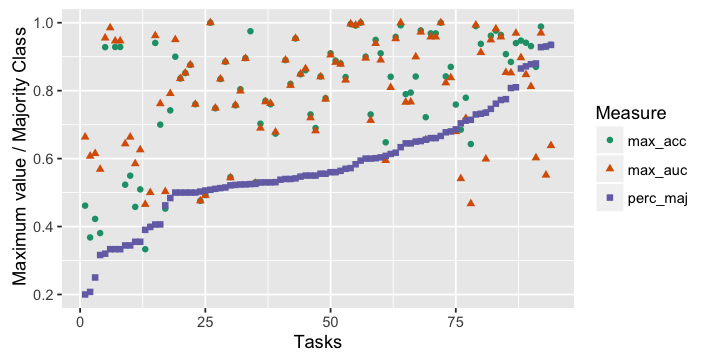

In [124]:
# Arguments:
#  * data: metled data frame return by getExperimentsData() function
# Output:
#  ggplot chart

getTasksInfoPlot = function(data) {

  # Getting additional information about the tasks
  tasks = unique(data$task.id)
  aux = lapply(tasks, function(task){
    sub = data[which(data$task.id == task), ]
    max.acc = max(sub$predictive.accuracy)
    max.auc = max(sub$area.under.roc.curve)
    maj.prop = max(sub$perMajClass)
    ret = c(max.acc, max.auc, maj.prop)
    return(ret)
  })

  # df = [task | max.acc | max.auc | % maj class ]
  df = data.frame(do.call("rbind", aux))
  colnames(df) = c("max_acc", "max_auc", "perc_maj")  
  df$tasks = tasks
  
  # sort them increasing the % of the maj class (tasks)
  df = df[order(df$perc_maj, decreasing = FALSE),]
  df$tasks = factor(df$tasks, levels = df$tasks)

  df.final = melt(df, id.vars = 4)
  colnames(df.final) = c("task", "Measure", "value")
  df.final$task = as.numeric(df.final$task)
 
  # generating the ggplot chart and returning it
  g = ggplot(data=df.final, aes(x=task, y=value, group=Measure, colour=Measure, shape=Measure)) 
  g = g + geom_point() + scale_colour_brewer(palette = "Dark2")
  g = g + ylab(" Maximum value / Majority Class") + xlab("Tasks")
  g = g + scale_x_continuous(limits = c(1, nrow(df)))
 
  return(g)
}

# Calling the function and showing the chart
options(repr.plot.width=6, repr.plot.height=3)
g = getTasksInfoPlot(data = data)
g

## 5. Simple performance analysis

With the previously defined we can now do some basic performance comparisons and generate plots based on them, such as, line plots, box plots, heap maps, and son on.

But first, we need to generate the a performance matrix according to a specific evaluation measure. Here, we are  generating the plots based on `measure = 'predictive.accuracy'`.

In [45]:
# Getting the performance matrix
mat.acc = getMatrix(data, column = "predictive.accuracy")
head(mat.acc)

,classif.IBk,classif.JRip,classif.J48,classif.LiblineaRL1LogReg,classif.LiblineaRL2LogReg,classif.OneR,classif.PART,classif.avNNet,classif.glmnet,classif.kknn,⋯,classif.sda,classif.svm,classif.xgboost,classif.xyf,classif.boosting,classif.glmboost,classif.blackboost,classif.plsdaCaret,classif.randomForestSRC,weka.ZeroR
3647,0.950000,0.925000,NA,0.95,0.95,0.891667,0.933333,0.966667,0.958333,0.966667,,0.95,0.966667,0.916667,0.966667,NA,0.958333,0.958333,0.958333,0.958333,NA
3577,0.000000,0.376923,0.446154,NA,NA,0.446154,0.269231,0.161538,0.138462,0.092308,,NA,0.176923,0.369231,NA,0.292308,NA,NA,NA,0.338462,NA
3731,0.869231,0.884615,0.838462,NA,NA,0.869231,0.830769,0.761538,0.861538,0.784615,,NA,0.807692,NA,NA,0.800000,0.884615,0.784615,NA,0.876923,NA
3729,0.910000,0.930000,0.930000,NA,NA,0.920000,0.930000,0.930000,0.930000,0.930000,,NA,0.930000,0.930000,NA,0.930000,NA,NA,NA,0.930000,NA
3739,0.810000,0.750000,0.810000,NA,NA,0.770000,0.800000,0.940000,0.920000,0.770000,,NA,0.810000,NA,NA,0.920000,0.860000,0.860000,NA,0.940000,NA
3876,0.934783,0.934783,0.934783,NA,NA,0.934783,0.934783,0.934783,0.934783,0.934783,,NA,0.934783,0.934783,NA,0.934783,0.934783,0.934783,NA,0.934783,NA


Now, we can generate the performance ranking via **getRanking** function. It will return an object with two slots:
* *rk* : is a matrix where each cell contains the algorithms ranking for a specific task; and 
* *rk.mean*: is the average ranking for all the algorithms evaluated over all the tasks.

Examples are shown in the commands below.

In [46]:
# Getting the accuracy rankings
rk.acc  = getRanking(mat.acc,  descending = TRUE)
head(rk.acc$rk)

,classif.IBk,classif.JRip,classif.J48,classif.LiblineaRL1LogReg,classif.LiblineaRL2LogReg,classif.OneR,classif.PART,classif.avNNet,classif.glmnet,classif.kknn,⋯,classif.sda,classif.svm,classif.xgboost,classif.xyf,classif.boosting,classif.glmboost,classif.blackboost,classif.plsdaCaret,classif.randomForestSRC,weka.ZeroR
3647,23.0,36.5,NA,23,23,43.0,34.5,5.0,13.5,5.0,,23,5.0,38.5,5,NA,13.5,13.5,13.5,13.5,NA
3577,24.5,6.0,3.5,NA,NA,3.5,13.0,17.0,20.0,21.5,,NA,15.0,7.0,NA,11.0,NA,NA,NA,8.0,NA
3731,7.5,1.5,16.5,NA,NA,7.5,20.0,33.0,12.0,30.0,,NA,26.5,NA,NA,28.0,1.5,30.0,NA,3.0,NA
3729,27.0,13.0,13.0,NA,NA,26.0,13.0,13.0,13.0,13.0,,NA,13.0,13.0,NA,13.0,NA,NA,NA,13.0,NA
3739,27.0,33.0,27.0,NA,NA,31.5,30.0,1.5,6.0,31.5,,NA,27.0,NA,NA,6.0,18.0,18.0,NA,1.5,NA
3876,17.5,17.5,17.5,NA,NA,17.5,17.5,17.5,17.5,17.5,,NA,17.5,17.5,NA,17.5,17.5,17.5,NA,17.5,NA


In [47]:
# Average rk values for each learner
head(rk.acc$rk.mean)

alg,rk.mean
classif.IBk,21.39583
classif.JRip,15.30000
classif.J48,13.93478
classif.LiblineaRL1LogReg,21.18182
classif.LiblineaRL2LogReg,19.54545
classif.OneR,24.45455


### a) Violin plot

With these information we can generate some chart/plots to visualize experiments results. One option is the violin plot: a similar analysis to box plots, except that they also show the probability density of the values. We can generate them based on the melted data frame, specifying the measure, and the design to export the chart (portrair or landscape).


Warning message:
"Removed 2 rows containing non-finite values (stat_ydensity)."Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."

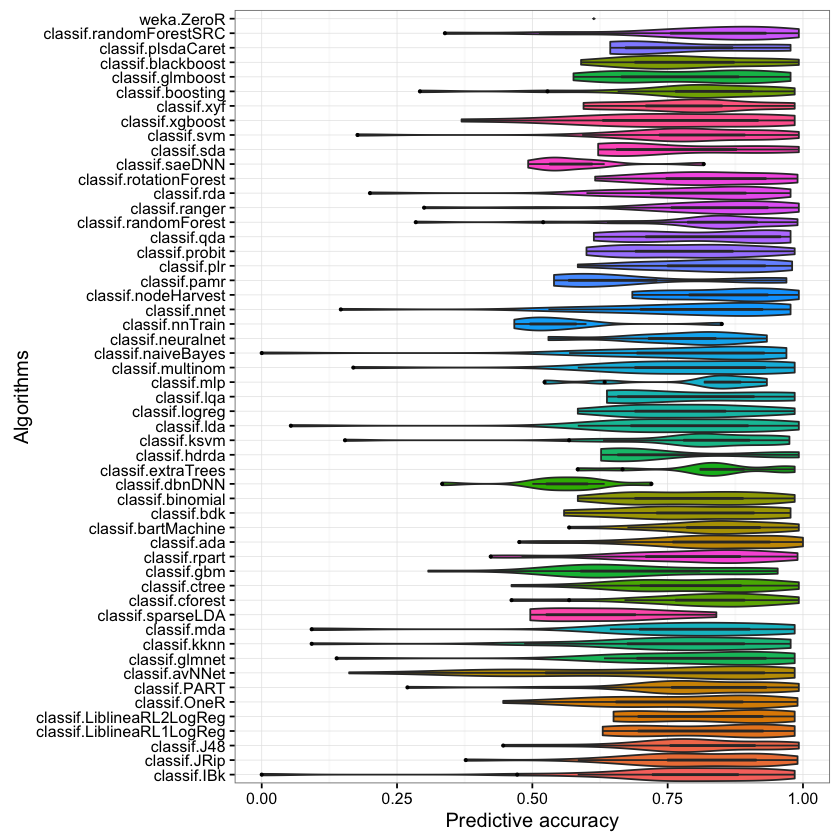

In [105]:
# Arguments
#  * data: metled data frame return by getExperimentsData() function
#  * measure: specified measure to be evaluated
#  * landscape: print the charts in the portrait or landscape format (it flips the coordinates)
# Output:
#  ggplot chart

getAlgosViolinPlot = function(data, measure = "predictive.accuracy", landscape = FALSE) {

  if(!(measure %in% c("predictive.accuracy", "area.under.roc.curve"))) {
    stopf("Invalid performance measure!")
  }
      
  chart.meas = ifelse(measure == "predictive.accuracy", "Predictive accuracy", "AUC")
  df = data.frame(data)
  temp = df[, c("algo", measure)]
  colnames(temp)[2] = "meas"
  
  g = ggplot(data = temp, mapping = aes(x = as.factor(algo), y = meas, fill = algo))
  g = g + geom_violin(trim = TRUE, scale = "width")
  g = g + geom_boxplot(outlier.colour = "black", outlier.size = 0.5, width = 0.1)
  g = g + scale_y_continuous(limits = c(0, 1))
  g = g + theme(text = element_text(size=10), axis.text.x = element_text(angle=90, vjust=.5, hjust=1))
  g = g + theme_bw() + theme(legend.position="none")
  g = g + ylab(chart.meas) + xlab("Algorithms") 

  if(landscape) {
    g = g + coord_flip()
  }
  return(g)
}

# Calling the function and showing the chart
g = getAlgosViolinPlot(data = data, measure = "predictive.accuracy", landscape = TRUE)
g  

### b) Boxplot

The same as we did with the violin plot, can be done to generate a boxplot. The arguments are the same as the previous one.

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."

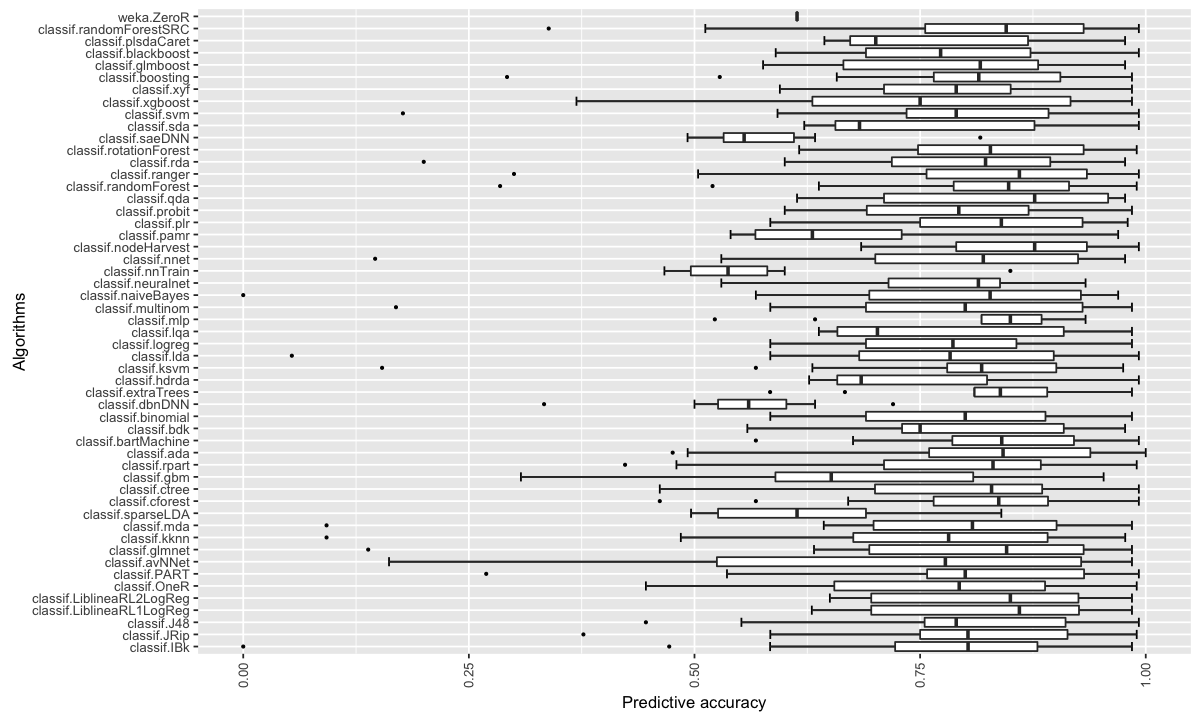

In [141]:
# Arguments
#  * data: metled data frame return by getExperimentsData() function
#  * measure: specified measure to be evaluated
#  * landscape: print the charts in the portrait or landscape format (it flips the coordinates)
# Output:
#  ggplot chart

getAlgosBoxPlot = function(data, measure = "predictive.accuracy", landscape = FALSE) {

  if(!(measure %in% c("predictive.accuracy", "area.under.roc.curve"))) {
    stopf("Invalid performance measure!")
  }
      
  chart.meas = ifelse(measure == "predictive.accuracy", "Predictive accuracy", "AUC")
  df = data.frame(data)
  temp = df[, c("algo", measure)]
  colnames(temp)[2] = "meas"
  
  g = ggplot(data = temp, mapping = aes(x = as.factor(algo), y = meas))
  g = g + stat_boxplot(geom ='errorbar')
  g = g + geom_boxplot(outlier.colour = "black", outlier.size = 0.5)
  g = g + scale_y_continuous(limits = c(0, 1))
  g = g + theme(text = element_text(size=10), axis.text.x = element_text(angle=90, vjust=.5, hjust=1))
  g = g + ylab(chart.meas) + xlab("Algorithms") 
  
  if(landscape) {
    g = g + coord_flip()
  }
  
  return(g)
}

# Calling the function and showing the chart
g = getAlgosBoxPlot(data = data, measure = "predictive.accuracy", landscape = TRUE)
g


### c) Ranking heat map

The function **getRankingHeatMap** gives a global vision of the ranks obtained in each task. It receives a matrix, returned by the **getRanking** function, and plot a gray-scale heat-map. Darker the values, better are the learners, corresponding to the best rank positions.


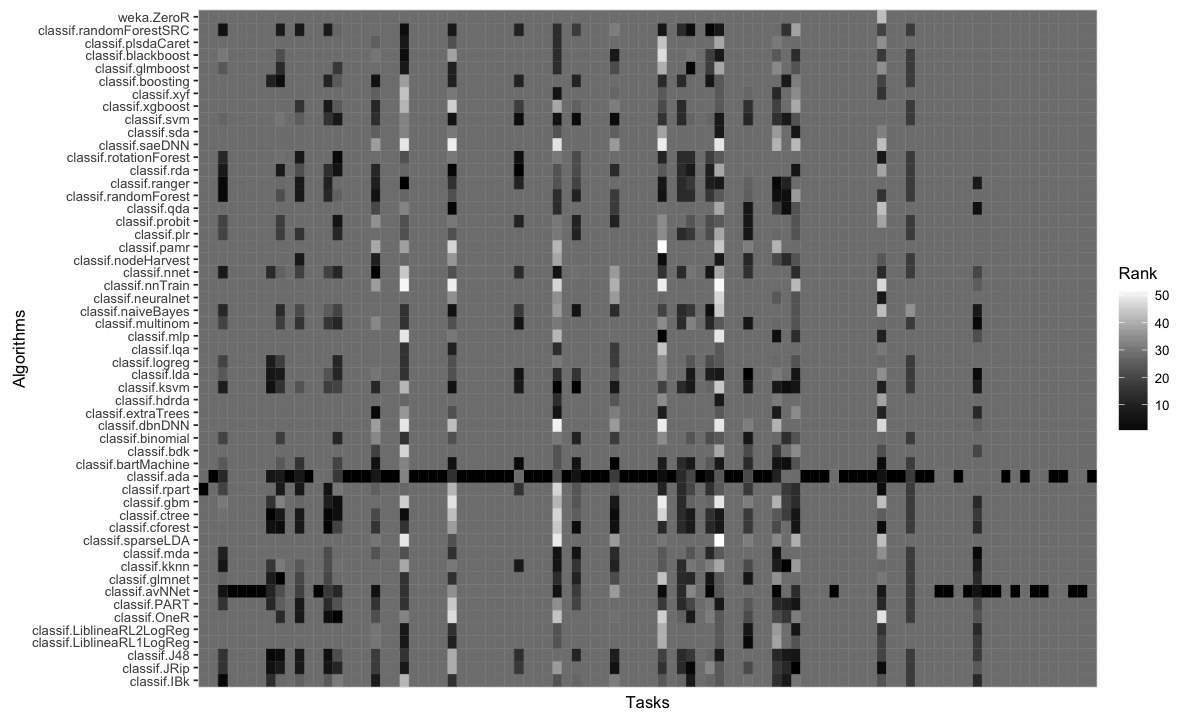

In [131]:
# Arguments:
#  * data: metled data frame return by getExperimentsData() function
# Output:
#  * ggplot chart

getRankingHeatMap = function(data) {

  data$task = rownames(data)
  rownames(data) = NULL

  df = melt(data, id.vars=ncol(data))
  colnames(df) = c("task", "algo", "Rank") 

  g = ggplot(df, aes(x = task, y = as.factor(algo), fill = Rank, colour = Rank))
  g = g + geom_tile() 
  g = g + scale_fill_gradient(low = "black", high = "white")
  g = g + scale_colour_gradient(low = "black", high = "white")
  g = g + scale_x_discrete(breaks = FALSE)
  g = g + theme(text = element_text(size = 10), axis.text.x = element_blank()) 
  g = g + xlab("Tasks") + ylab("Algorithms")

  return(g)
}

# Calling the function and showing the chart
options(repr.plot.width=10, repr.plot.height=6)
g = getRankingHeatMap(data = rk.acc$rk)
g
   

### d) Ranking frequency

The function **getRankFrequencyPlot** receives a rank object and the melted data, plotting how many times (or the percentage of times) that each algorithm appears in the **k** first rank positions. It also uses the runtime to "*penalize*" the algorithms, more red the bar, more time consuming is the algorithm.


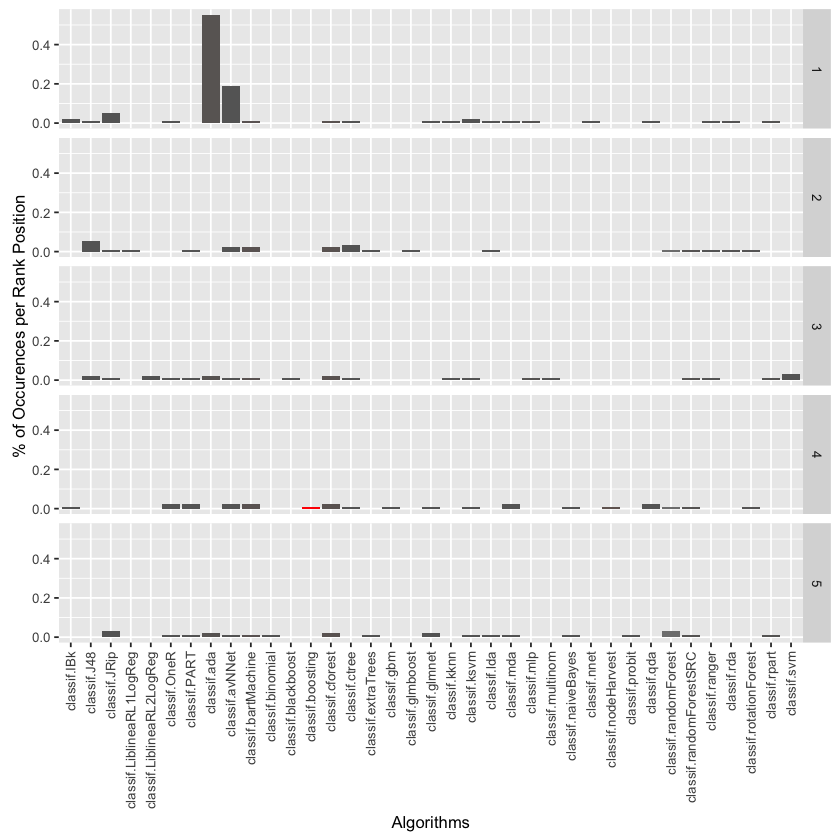

In [108]:
# Arguments:
#  * rk: the ranking generated by getRanking() function
#  * data: metled data frame return by getExperimentsData() function
#  * k: number of positions to be considered in the plot (k-rank)
#  * version: using absolute of percentage values

getRankFrequencyPlot = function(rk, data, k = 5, version = "percentage"){

  data.runtime = getRuntime(data)
  all.learners = unique(data$algo)
  mat = rk$rk

  # k-best algorithms
  aux = lapply(1:nrow(mat), function(i){
    algos.ids = which(!is.na(mat[i,]))
    temp = mat[i, algos.ids]
    ret = sort(temp, decreasing = FALSE)

    if( length(algos.ids) == 1) {
      alg.names = colnames(mat)[algos.ids]
    } else{
      alg.names = names(ret)
    }

    obj = c(alg.names, rep(x=NA, times=(length(all.learners) - length(temp))))
    return(obj)
  })
  aux = data.frame(do.call("rbind", aux))
  
  #list of k-best
  temp = lapply(1:k, function(i){
    return(table(factor(aux[,i], levels = all.learners)))
  })

  # df with the best learners
  rk.df = data.frame(do.call("cbind", temp))
  colnames(rk.df) = c(1:ncol(rk.df))
  rk.df$alg = rownames(rk.df)
  rownames(rk.df) = NULL

  # Adding runtime on the data frame
  rk.df$runtime = 0
  for(i in 1:nrow(rk.df)){
    id = which(data.runtime$alg == rk.df$alg[i])
    if(length(id) != 0) {
      value = data.runtime$total[id]
      rk.df$runtime[i] = value
    }
  }

  df = melt(rk.df, id.vars = c(ncol(rk.df) - 1, ncol(rk.df)))
  colnames(df) = c("learner", "runtime", "rank", "value")
  df = df[which(df$value != 0),]

  if(version == "percentage") {
    df$value = df$value / length(unique(data$task.id))
  }
  
  g = ggplot(data = df, aes(x=learner, y=value, fill=runtime)) 
  g = g + geom_bar(position="dodge",stat="identity") + guides(fill=FALSE)
  g = g + scale_y_continuous(limits = c(0, max(df$value))) + facet_grid(rank ~ .)
  g = g + theme(text = element_text(size=10), axis.text.x = element_text(angle=90, vjust=.5, hjust=1)) 
  g = g + xlab("Algorithms") + scale_fill_gradient(high="red", low="grey40")

  if(version == "percentage") {
    g = g + ylab("% of Occurences per Rank Position") 
  } else {
    g = g + ylab("Occurences per Rank Position") 
  }

  return(g)
}

# Calling the function and showing the chart
g = getRankFrequencyPlot(rk = rk.acc, data = data, k = 5, version = "percentage")
g  


## 6. Runtime Analysis

Evaluating the runtime information basically use the same functions. First, we also need to generate the runtime matrix and the average rankings.

In [52]:
temp = data
temp$runtime = data$training.time + data$testing.time
mat.time = getMatrix(temp, column = "runtime")
head(mat.time)

,classif.IBk,classif.JRip,classif.J48,classif.LiblineaRL1LogReg,classif.LiblineaRL2LogReg,classif.OneR,classif.PART,classif.avNNet,classif.glmnet,classif.kknn,⋯,classif.sda,classif.svm,classif.xgboost,classif.xyf,classif.boosting,classif.glmboost,classif.blackboost,classif.plsdaCaret,classif.randomForestSRC,weka.ZeroR
3647,0.727,0.667,NA,0.03,0.021,0.572,0.829,0.623,0.171,0.048,,0.092,0.070,0.045,0.179,NA,0.356,0.525,0.057,1.791,NA
3577,0.861,1.166,1.089,NA,NA,0.797,1.092,0.442,4.636,0.055,,NA,0.233,0.074,NA,5724.605,NA,NA,NA,18.868,NA
3731,1.166,0.956,1.097,NA,NA,0.992,1.017,1.249,0.510,0.088,,NA,0.194,NA,NA,283.312,0.511,0.849,NA,13.289,NA
3729,0.729,0.686,1.028,NA,NA,0.531,0.732,0.805,0.231,0.054,,NA,0.162,0.082,NA,270.028,NA,NA,NA,1.670,NA
3739,0.955,0.947,1.115,NA,NA,0.700,1.072,0.938,0.391,0.064,,NA,0.159,NA,NA,281.936,0.600,0.595,NA,5.071,NA
3876,0.840,0.637,0.893,NA,NA,0.451,0.638,0.546,0.176,0.045,,NA,0.087,0.032,NA,448.017,0.516,0.452,NA,2.633,NA


### a) Line plot

The first analysis regarding runtime shows a line plot with the average {training, testing and total} runtimes. 
The algorithms are ascending order according to the average total runtime {training + testing time}. The x-axis presents each algorithm while the y-axis shows the average runtime values (in the log scale).

Warning message:
"Removed 6 rows containing missing values (geom_path)."Warning message:
"Removed 6 rows containing missing values (geom_point)."

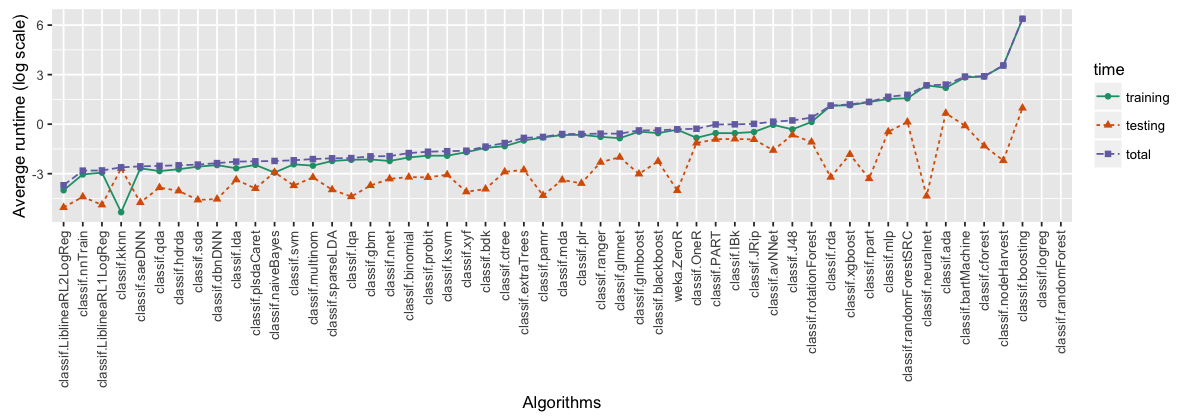

In [127]:
# Arguments
#  * data: metled data frame return by getExperimentsData() function
# Output:
#  * ggplot chart

getRuntimeLinePlot = function(data) {

  temp = getRuntime(data)
  aux  = temp[order(temp$total, decreasing = FALSE),]
  aux$alg = factor(aux$alg, levels = aux$alg)

  aux.final = melt(aux, id.vars = 4)   
  colnames(aux.final) = c("alg", "time", "value")

  g = ggplot(data=aux.final, aes(x=alg, y=log(value), colour=time, group=time, linetype=time, shape=time))
  g = g + geom_line() + geom_point()
  g = g + theme(text = element_text(size=10), axis.text.x = element_text(angle=90, vjust=.5, hjust=1))
  g = g + scale_colour_brewer(palette="Dark2")
  g = g + ylab("Average runtime (log scale)") + xlab("Algorithms")
  
  return(g)
}

# Calling the function and showing the chart
options(repr.plot.width=10, repr.plot.height=3.5)
g = getRuntimeLinePlot(data = data)
g

### b) Boxplot

Like with the accuracies, we also can generate the boxplot regarding runtimes. It receives the melted data frame and returns the plot. It is possible to choose in which design (portrait or landscape) the chart will be exported/generated.

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."

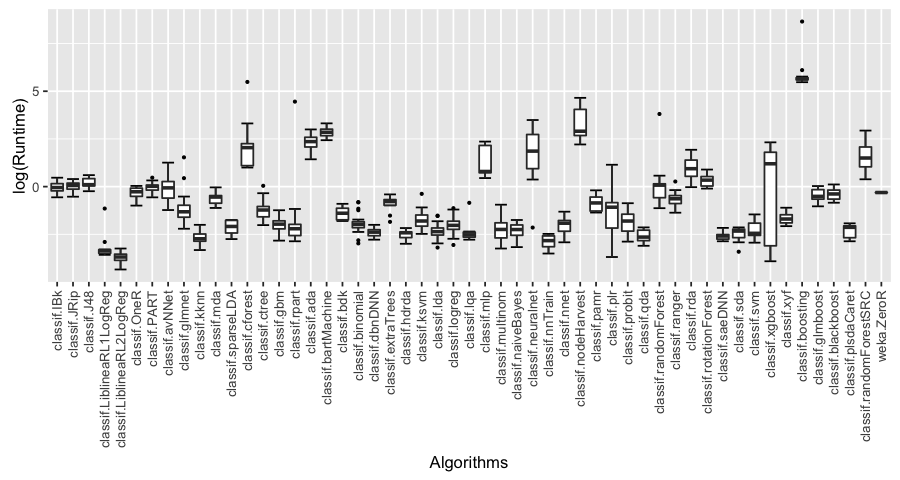

In [138]:
# Arguments:
#  * data: metled data frame return by getExperimentsData() function
#  * landscape: flip the coordinates of the chart and print it in a ladscape design (default is FALSE)
# Output:
#  * ggplot chart

getRuntimeBoxplot = function(data, landscape = FALSE) {

  df   = data.frame(data)
  temp = df[, c("algo", "training.time", "testing.time")]
  temp$runtime = temp$training.time + temp$testing.time
  
  g = ggplot(data = temp, mapping = aes(x = as.factor(algo), y = log(runtime)))
  g = g + stat_boxplot(geom ='errorbar')
  g = g + geom_boxplot(outlier.colour = "black", outlier.size = 0.5)
  g = g + theme(text = element_text(size = 10), axis.text.x = element_text(angle = 90, vjust = .5, hjust = 1))
  g = g + ylab("log(Runtime)") + xlab("Algorithms")

  if(landscape) {
    g = g + coord_flip()
  }

  return(g)
}

# Calling the function and showing the chart
options(repr.plot.width=7.5, repr.plot.height=4)
g = getRuntimeBoxplot(data = data, landscape = FALSE)
g


### c) Ranking heatmap plot

Basically, plots a heap map with the a global overview of the rankings. Darker the cell, better was the learner (faster) in that task.



In [54]:
rk.time  = getRanking(mat.time, descending = FALSE)
head(rk.time$rk)

,classif.IBk,classif.JRip,classif.J48,classif.LiblineaRL1LogReg,classif.LiblineaRL2LogReg,classif.OneR,classif.PART,classif.avNNet,classif.glmnet,classif.kknn,⋯,classif.sda,classif.svm,classif.xgboost,classif.xyf,classif.boosting,classif.glmboost,classif.blackboost,classif.plsdaCaret,classif.randomForestSRC,weka.ZeroR
3647,40,39,NA,2,1,37,41,38,25,4,,16,8.5,3,26,NA,32,36,5,43,NA
3577,13,17,15,NA,NA,12,16,9,20,1,,NA,6.0,2,NA,25,NA,NA,NA,21,NA
3731,25,21,24,NA,NA,22,23,26,16,1,,NA,4.0,NA,NA,33,17,20,NA,30,NA
3729,17,16,20,NA,NA,15,18,19,10,1,,NA,6.0,2,NA,27,NA,NA,NA,23,NA
3739,23,22,25,NA,NA,20,24,21,15,1,,NA,9.0,NA,NA,33,19,18,NA,28,NA
3876,25,23,26,NA,NA,17,24,21,11,2,,NA,4.0,1,NA,35,20,18,NA,30,NA


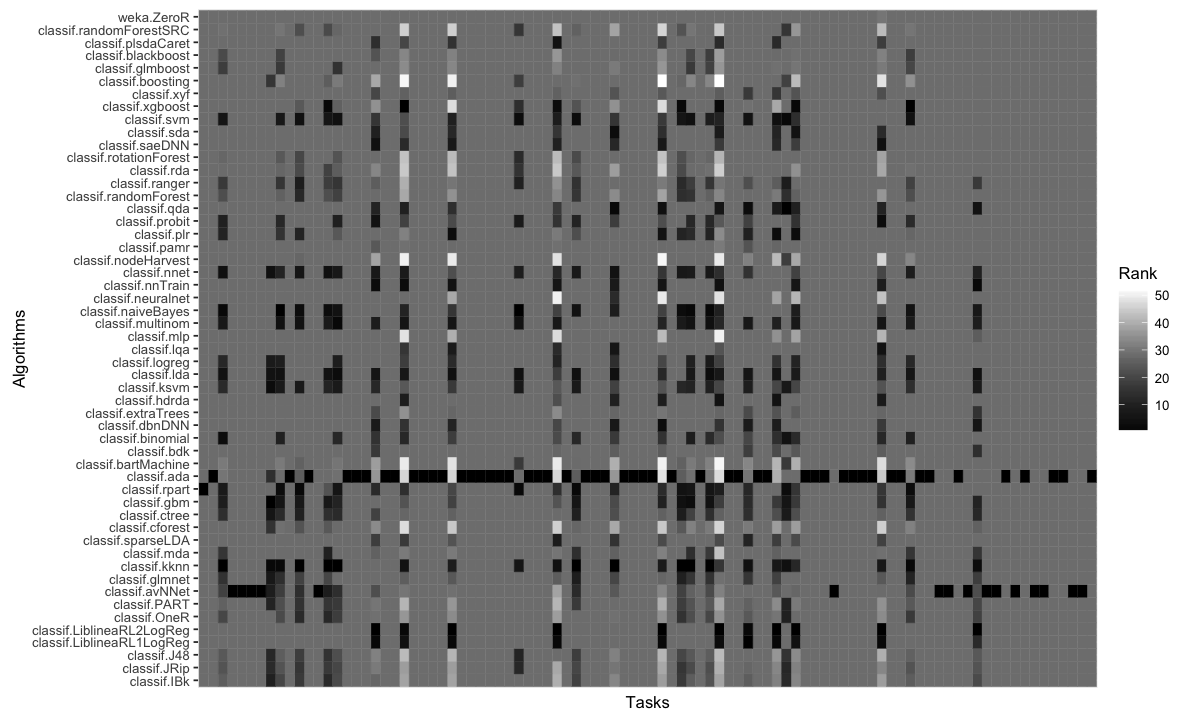

In [139]:
# Calling the function and showing the chart
options(repr.plot.width=10, repr.plot.height=6)
g = getRankingHeatMap(data = rk.time$rk)
g   

## 7. Maximum Performance Analysis

Warning message:
"Removed 4032 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 4032 rows containing non-finite values (stat_boxplot)."

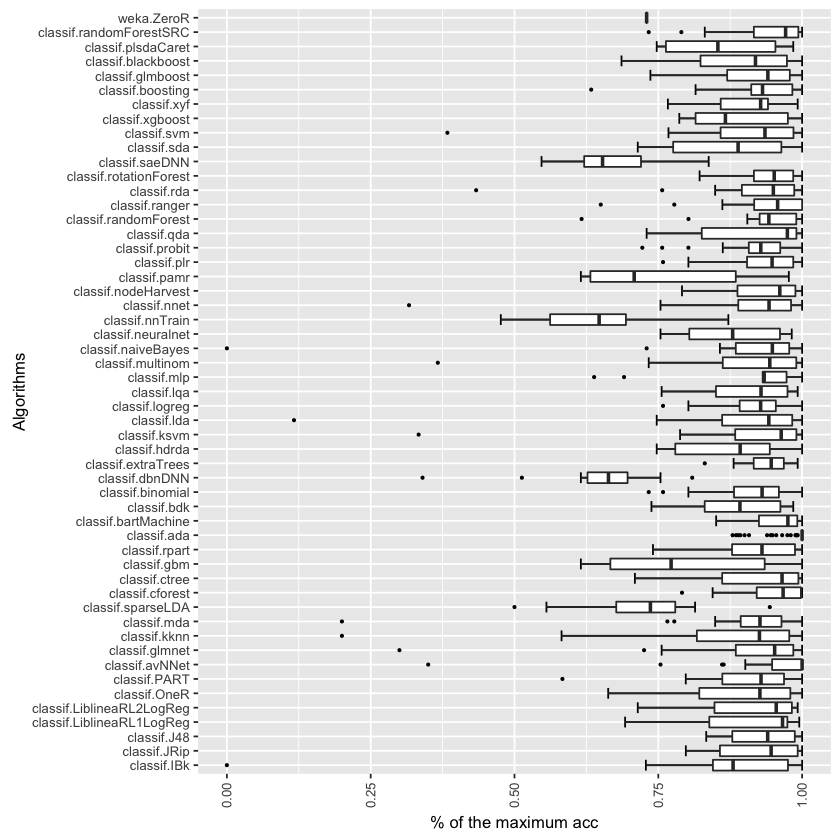

In [113]:
# Arguments:
#  * data: metled data frame return by getExperimentsData() function
#  * tasks: 
#  * chart: boxplot, heatmap or violin
#  * prefix: 
#  * landscape: flip the coordinates of the chart and print it in a ladscape design (default is FALSE)
# Output:
#  * 

getMaxPerfSinglePlotByMeasure = function(data, tasks, chart = "boxplot", prefix = NULL, landscape = FALSE) {

  if(!(chart %in% c("boxplot", "heatmap", "violin"))) {
    stop(" - Invalid type of plot: choose between \'boxplot\', \'heatmap\' or \'violin\'.\n")
  }

  ids = which(data$NumberOfClasses == 2)
  binary.tasks = unique(data[ids, "task.id"])
  bin.rows = which(rownames(tasks) %in% binary.tasks)

  multic.tasks = unique(data[-ids, "task.id"])
  mlt.rows = which(rownames(tasks) %in% multic.tasks)
  tasks = tasks[c(mlt.rows, bin.rows), ]
 
  if(chart != "boxplot") {
    tasks[is.na(tasks)] = 0
  }

  tasks$task = gsub("OpenML-Task-", "", rownames(tasks))
  rownames(tasks) = NULL

  df = melt(tasks, id.vars = ncol(tasks))
  colnames(df)[2] = "algo"

  g = NULL
  if(chart == "heatmap") {

    df$task = as.factor(df$task)
    colnames(df)[3] = "percentage"

    g = ggplot(df, aes(x = task, y = as.factor(algo), fill=percentage, colour=percentage))
    g = g + geom_tile() 
    g = g + scale_fill_gradient(low = "white", high = "black")
    g = g + scale_colour_gradient(low = "white", high = "black")
    g = g + scale_x_discrete(breaks = FALSE)
    g = g + theme(text = element_text(size = 10), axis.text.x = element_blank()) 
    g = g + xlab("Tasks") + ylab("Algorithms")
    g = g + ggtitle("Percentage of the maximum performance over all the tasks")
 
  } else if (chart == "boxplot") {
  
    g = ggplot(data = df, mapping = aes(x = as.factor(algo), y = value))
    g = g + stat_boxplot(geom ='errorbar')
    g = g + geom_boxplot(outlier.colour = "black", outlier.size = 0.5)
    g = g + theme(text = element_text(size = 10), axis.text.x = element_text(angle = 90, vjust = .5, hjust = 1))
    g = g + ylab(paste0("% of the maximum ", gsub("_", "", prefix))) + xlab("Algorithms")
    g = g + scale_y_continuous(limits = c(0, 1))
  
  } else {
  
    g = ggplot(data = df, mapping = aes(x = as.factor(algo), y = value, fill = algo))
    g = g + geom_violin(trim = TRUE, scale = "width") #fill = '#FFCCFF')
    g = g + geom_boxplot(outlier.colour = "black", outlier.size = 0.5, width = 0.1)
    g = g + scale_y_continuous(limits = c(0, 1))
    g = g + theme(text = element_text(size = 10), axis.text.x = element_text(angle = 90, vjust = .5, hjust = 1))
    g = g + theme_bw() + theme(legend.position="none")  
    g = g + ylab(paste0("% of the maximum ", gsub("_", "", prefix))) + xlab("Algorithms")
  
  }

  if(landscape) {
    g = g + coord_flip()
  }
  
  return(g)
}


# Boxplot of the maximum peformance
tasks.acc = getMaxPerfMatrix(mat.acc)
g = getMaxPerfSinglePlotByMeasure(data, tasks.acc, chart = "boxplot", prefix = "acc", landscape = TRUE)
g  

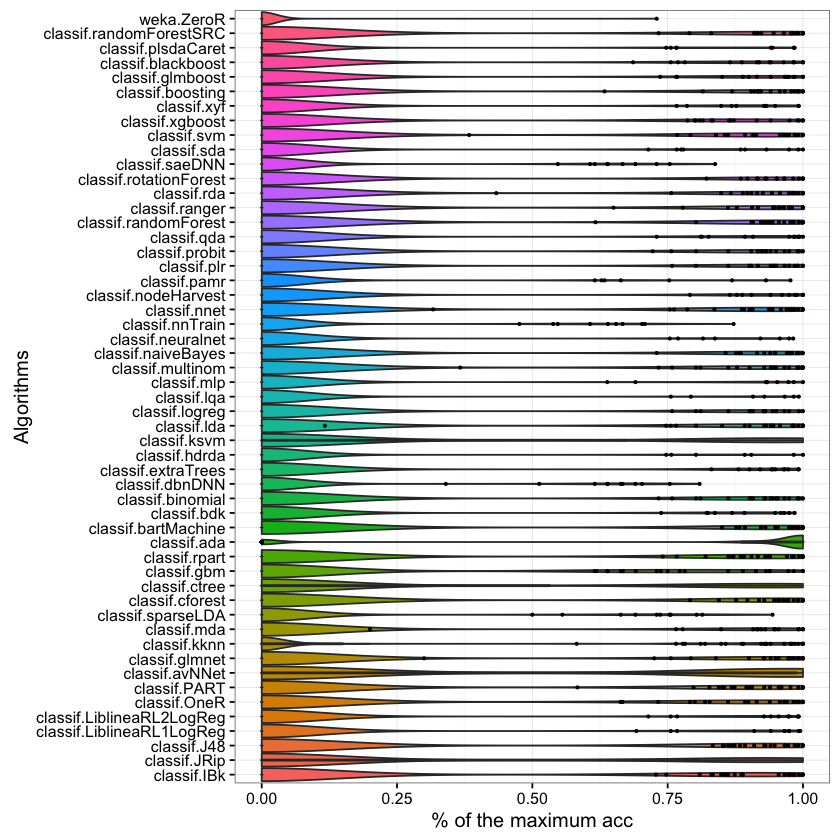

In [114]:
g = getMaxPerfSinglePlotByMeasure(data, tasks.acc, chart = "violin", prefix = "acc", landscape = TRUE)
g

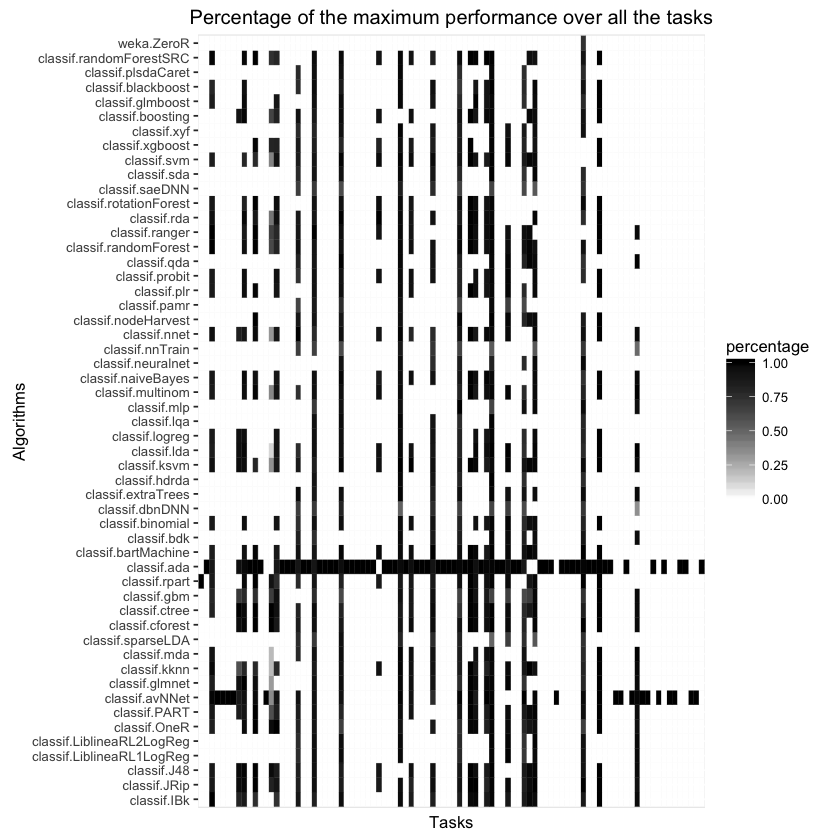

In [78]:
g = getMaxPerfSinglePlotByMeasure(data, tasks.acc, chart = "heatmap", prefix = "acc")
g  

## 8. Multiple analysis

In [82]:
getMatrixAucRuntime = function(data, w = 0.1){

  all.learners = unique(data$algo)
  all.tasks = unique(data$task.id)

  mat = matrix(data = NA, nrow = length(all.tasks), ncol = length(all.learners), 
    dimnames = list(all.tasks, all.learners))
  
  temp = data
  temp$total.time.log = log(1 + temp$training.time + temp$testing.time)

  # Matrices with the specified measure (by the id arg)
  for(i in 1:nrow(temp)) { 
    row.id = which(all.tasks == temp[i,]$task.id)
    col.id = which(all.learners == temp[i,]$algo)
    mat[row.id, col.id] = temp$area.under.roc.curve[i] - (temp$total.time.log[i] * w)
  }
  
  # Removing algs with no execution (not being applied on all tasks)
  uniquelength = sapply(data.frame(mat), function(x) length(unique(x)))
  mat = subset(data.frame(mat), select = uniquelength > 1)
  mat[mat < 0] = 0
  
  return(mat)
}


In [83]:
mat.auc  = getMatrix(data, column = "area.under.roc.curve")
mat.comp = getMatrixAucRuntime(data, w = 0.1)

temp = data
temp$runtime = data$training.time + data$testing.time
mat.time = getMatrix(temp, column = "runtime")
 
rk.auc  = getRanking(mat.auc,  descending = TRUE) 
rk.comp = getRanking(mat.comp, descending = TRUE) 
  
# binding average ranking for each measure (rk with the 3 different measures)
rk.full = data.frame(cbind(rk.acc$rk.mean, rk.auc$rk.mean[,2], rk.comp$rk.mean[,2]))
colnames(rk.full) = c("alg", "rk_acc", "rk_auc", "rk_auc_run")

 

Warning message:
"Removed 4 rows containing missing values (geom_point)."

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]

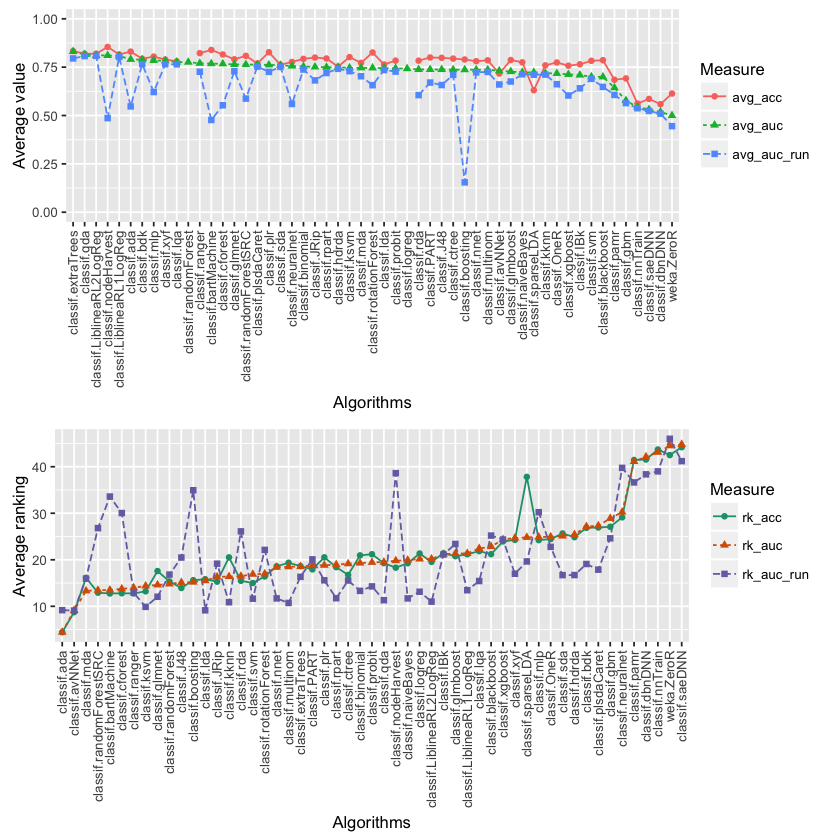

In [88]:
# Arugments:
#  * data:
#  * rk.full:
#  * export: boolean to export as an object able to be saved by ggsave. If FALSE, just print 

getAlgosAvegPerfLinePlot = function(data, rk.full, export = TRUE) {

  algos = unique(data$algo)
  aux = lapply(algos, function(alg) {
    ids = which(data$algo == alg)
    acc = mean(data[ids, "predictive.accuracy"])

    real.ids = which(!is.na(data[ids, "area.under.roc.curve"]))
    auc = mean(data[ids, "area.under.roc.curve"][real.ids])
        
    auc_run = mean(data[ids, "area.under.roc.curve"][real.ids] 
      - ( log(1 + data[ids, "training.time"][real.ids] 
       + data[ids, "testing.time"][real.ids])) * 0.1)
        
    ret = c(acc, auc, auc_run)
    return(ret)
  })

  aux = data.frame(do.call("rbind", aux))
  aux$alg = algos
  colnames(aux) = c("avg_acc", "avg_auc", "avg_auc_run", "alg")
 
  aux = aux[order(aux$avg_auc, decreasing = TRUE), ]
  aux$alg = factor(aux$alg, levels = aux$alg)
  df1 = melt(aux, id.vars = 4)
  colnames(df1)[2] = "Measure"

  g1 = ggplot(data = df1, aes(x = alg, y = value, group = Measure, colour = Measure, 
    linetype = Measure, shape = Measure)) 
  g1 = g1 + geom_line() + geom_point() 
  g1 = g1 + theme(text = element_text(size=10),axis.text.x = element_text(angle=90, vjust=.5, hjust=1))
  g1 = g1 + scale_y_continuous(limits = c(0, 1))
  g1 = g1 + ylab("Average value") + xlab("Algorithms")
 
  df2 = rk.full[order(rk.full$rk_auc, decreasing = FALSE), ]
  df2$alg = factor(df2$alg, levels = df2$alg)
  df2 = melt(df2, id.vars = 1) 
  colnames(df2)[2] = "Measure"

  # Plot 2 (average rankings)
  g2 = ggplot(data=df2, aes(x=alg, y = value, group = Measure, colour = Measure, 
    linetype = Measure, shape = Measure)) 
  g2 = g2 + geom_line() + geom_point() 
  g2 = g2 + theme(text = element_text(size=10), axis.text.x = element_text(angle=90, vjust=.5, hjust=1))
  g2 = g2 + scale_colour_brewer(palette="Dark2")
  g2 = g2 + ylab("Average ranking") + xlab("Algorithms")

  if (export) {
    double.g = gridExtra::arrangeGrob(g1, g2, ncol = 1, nrow = 2)
  } else { 
    double.g = gridExtra::grid.arrange(g1, g2, ncol = 1, nrow = 2)
  }
  return(double.g)
}
 
# Retuning the compose chart and showing it
g = getAlgosAvegPerfLinePlot(data = data, rk.full = rk.full, export = FALSE)
g 

## Recap

...

If you want you can reproduce the analysis using a different performance measure.